# Verkeersborden herkennen met Tensorflow

Github: https://github.com/rwsdatalab/verkeersborden

Dit notebook is het eerste deel van een tutorial waarin we met deep learning verkeersborden gaan herkennen. Het doel van dit deel is om kort uit te leggen wat deep learning is, en vervolgens een eerste model te bouwen en te evalueren. Dit project is geinspireerd door deze [pagina](https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6)

## Neurale Netwerken
Neurale Netwerken (NN's) zijn computer programma's die patronen kunnen herkennen. Ze zijn geinspireerd op hoe hersenen zijn ontworpen: Neuronen (Nodes) die aan elkaar verbonden zijn en leren hoe ze moeten reageren op inkomende signalen. Die nodes zijn georganiseerd in lagen.

NN's bestaan al jaren, maar zijn tegenwoordig weer populair omdat de techniek toelaat dat we veel lagen gebruiken: Deep Learning.

Dit notebook leert je een vrij ondiep netwerk te bouwen met behulp van Tensorflow. Meer in deel 2.

## Eerste poging: Verkeersborden classificeren
Gegeven een afbeelding van een verkeersbord zullen we moeten bepalen wat voor verkeersbord we zien (bijvoorbeeld: Een voorrangsbord of een stopteken).

Voor de project gebruiken we Python 3.5 en de libraries Tensorflow, Numpy, Sci-kit Image, and Matplotlib. Deze libraries zijn al in de environment die we net hebben aagemaakt geïnstalleerd. Vervolgens gaan we de libraries importeren, dit doen  we met het commando 'import':

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import random
import numpy as np
# Allow image embeding in notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Imaging
# import skimage.data
import cv2
import skimage.transform
# ML models
import tensorflow as tf
# Various
import zipfile
print("inladen libraries is klaar!")

inladen libraries is klaar!


## Training Dataset

We gebruiken in dit project een verzameling verkeersborden uit [Belgie](http://btsd.ethz.ch/shareddata/). De beelden zijn opgedeeld in twee mappen:

```
/data/Training/
/data/Testing/
```
Beide directories hebben 62 sub-directories (0000 tot 0061). De naam van de sub-directory representeert het type verkeersborden (het label). 

Als we de volgende twee cellen runnen, dan worden de afbeeldingen en labels (Training, Testing) gedownload onder de map datasets. 

In [ ]:
!wget -nc https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
with zipfile.ZipFile("BelgiumTSC_Training.zip") as zf:
  zf.extractall("../data/")

File ‘BelgiumTSC_Training.zip’ already there; not retrieving.



In [ ]:
!wget -nc https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

with zipfile.ZipFile("BelgiumTSC_Testing.zip") as zf:
  zf.extractall("../data/")

File ‘BelgiumTSC_Testing.zip’ already there; not retrieving.



In [ ]:
# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "../data/Training")
test_data_dir = os.path.join(ROOT_PATH, "../data/Testing")

## De traindata inladen

Vervolgens gaan we data die we net gedownload hebben, inladen in Python met een functie def load_data die we hier aanmaken.

In [ ]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels


images, labels = load_data(train_data_dir)

print("Data is ingeladen in Python!")

Data is ingeladen in Python!


We hebben nu twee lijsten:

* **images** een lijst van plaatjes in de vorm van een numpy array.
* **labels** een lijst met labels in de vom van een array van getallen van 0 tot en met 61

De lijsten staan met elkaar in verbinding doo de gehanteerde volgorde.

## De data verkennen

In [ ]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


Hieronder maken we een tabel met van elk label het eerste voorbeeld.

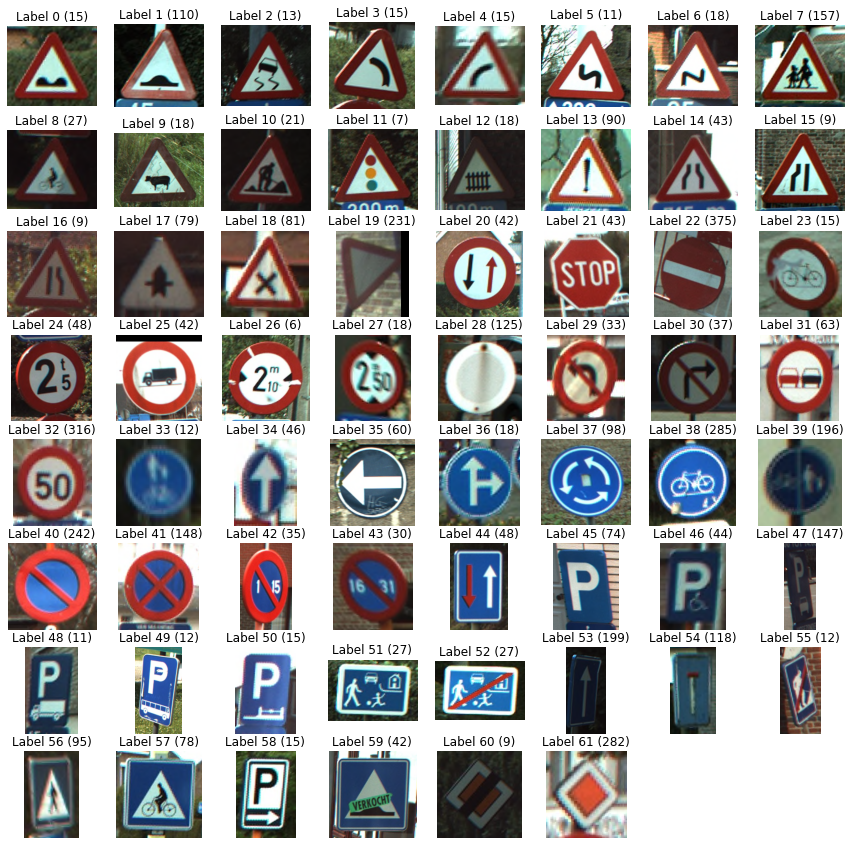

In [ ]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image[..., ::-1])
    plt.show()

display_images_and_labels(images, labels)

Kijk eens! Dat ziet er goed uit! Zo te zien hebben we van alle verkeersborden een plaatje dat min of meer het hele beeld vult. Het valt wel op dat de plaatjes niet helemaal vierkant zijn, dat moeten we later wel oplossen. 

Laten we eerst nog eens een type wat meer in detail bekijken. Laten we eens beginnen met type 42.

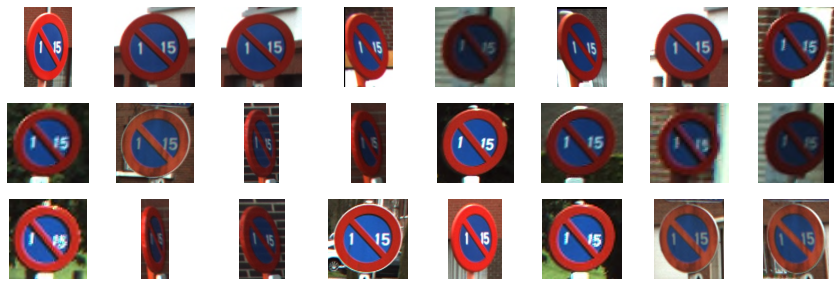

In [ ]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image[..., ::-1])
    plt.show()

display_label_images(images, 42)

Ahah! Alle snelheidsgeboden vallen in dezelfde klasse. Tensorflow zou daar in principe mee om mee moeten kunnen gaan, maar het is wel goed om dit even gezien te hebben.

Kan je nu zelf andere klasses bekijken? Probeer bijvoorbeeld eens 26 en 27 te bekijken. Wat zou dit straks kunnen betekenen?

## Verschillende formaten
 
Het is over het algemeen handig om de plaatjes in hetzelfde formaat te hebben. We hebben al gezien dat dat in dit geval niet zo is. Een goede manier om dit op te lossen is om de plaatjes handmatig bij te knippen zodat we geen belangrijke delen missen.

Vandaag pakken we het snel aan, dus gaan we voor een hack: We schalen de plaatjes automatisch zonde te knippen. We gooien dus niks weg maar vervormen de beelden dus licht.

Hoe groot zijn de plaatjes?

In [ ]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (120, 122, 3), min: 16, max: 255
shape: (107, 104, 3), min: 13, max: 244
shape: (145, 96, 3), min: 2, max: 255
shape: (117, 115, 3), min: 5, max: 255
shape: (64, 62, 3), min: 14, max: 250


Rond de 128 bij 128 dus. Als we ze nou eens allemaal afbeelden op 32x32, dan hebben we minder data (dus sneller resultaat) en ze zijn allemaal van hetzelfde formaat.

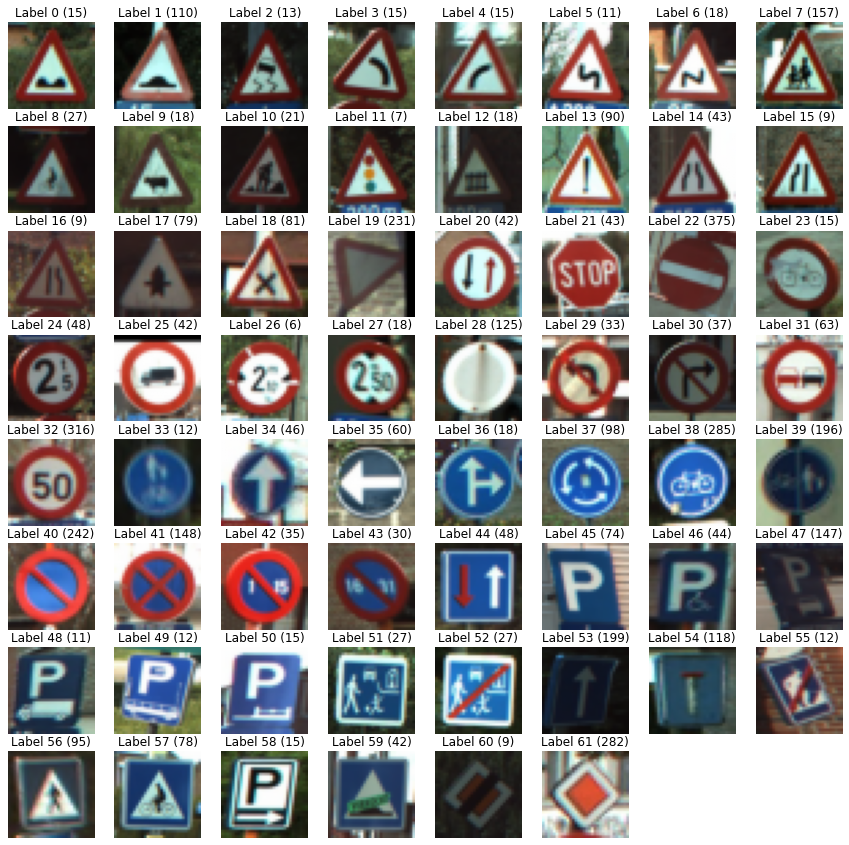

In [ ]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

Minder scherp, maar nog steeds herkenbaar!

# Minimum Viable Model
Nu bouwen we een simpel neuraal netwerk dat plaatjes voor ons gaat classificeren. Het bestaat uit twee input tensors (de plaatjes en de labels), een tussenlaagje dat de plaatjes plat maakt, gevolgd door een fully connected layer die de voorspelling maakt.

Een fully connected layer verbindt alle inputs naar elk van zijn eigen nodes. Deze layer heeft er 62 (een voor elke klasse).

In [ ]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(62, activation="relu")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 16)                49168     
                                                                 
 dense_1 (Dense)             (None, 62)                1054      
                                                                 
Total params: 50,222
Trainable params: 50,222
Non-trainable params: 0
_________________________________________________________________


## Training
We gaan het model nu 200 keer trainen. (We gebruiken de ADAM optimizer om de cross-entropy zo laag mogelijk te krijgen)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
print("Fit model on training data")
history = model.fit(
    images_a,
    labels_a,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    #validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/100
72/72 [==============================] - 1s 3ms/step - loss: 3.6474 - sparse_categorical_accuracy: 0.2085
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 2.9703 - sparse_categorical_accuracy: 0.3751
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 2.5882 - sparse_categorical_accuracy: 0.4758
Epoch 4/100
72/72 [==============================] - 0s 3ms/step - loss: 2.3876 - sparse_categorical_accuracy: 0.5089
Epoch 5/100
72/72 [==============================] - 0s 3ms/step - loss: 2.2454 - sparse_categorical_accuracy: 0.5386
Epoch 6/100
72/72 [==============================] - 0s 3ms/step - loss: 2.1537 - sparse_categorical_accuracy: 0.5587
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 2.0662 - sparse_categorical_accuracy: 0.5873
Epoch 8/100
72/72 [==============================] - 0s 3ms/step - loss: 2.0079 - sparse_categorical_accuracy: 0.5904
Epoch 9/100
72/72 [==========

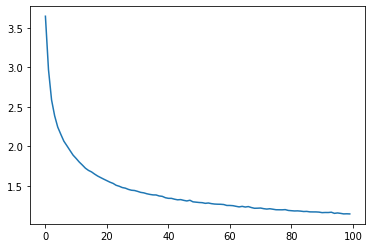

In [ ]:
plt.plot(history.history["loss"])

## Het model toepassen

Laten we eens kijken welk percentage ons model nu goed heeft.

In [ ]:
np.mean(np.argmax(model.predict(images_a), axis=1) == labels_a)

0.7392349726775956

Alright een percentage rond de ??% procent... klinkt goed!

Hoe ziet dat er dan uit?

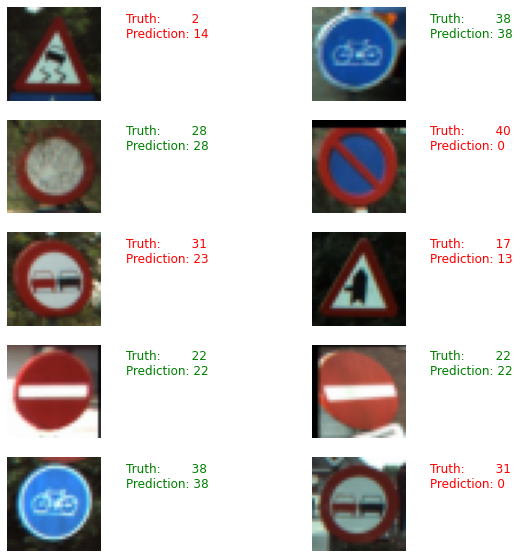

In [ ]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = np.array([images32[i] for i in sample_indexes])
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = np.argmax(model.predict(sample_images),axis=1)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):

    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i][..., ::-1])


## Evaluatie

Het is aardig dat we nu goed scoren op de trainset, maar goed dit model nu ook echt iets geleerd?

Daar hebben we de testset voor, weet je nog?

In [ ]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

print("de testset is ingeladen!")

de testset is ingeladen!


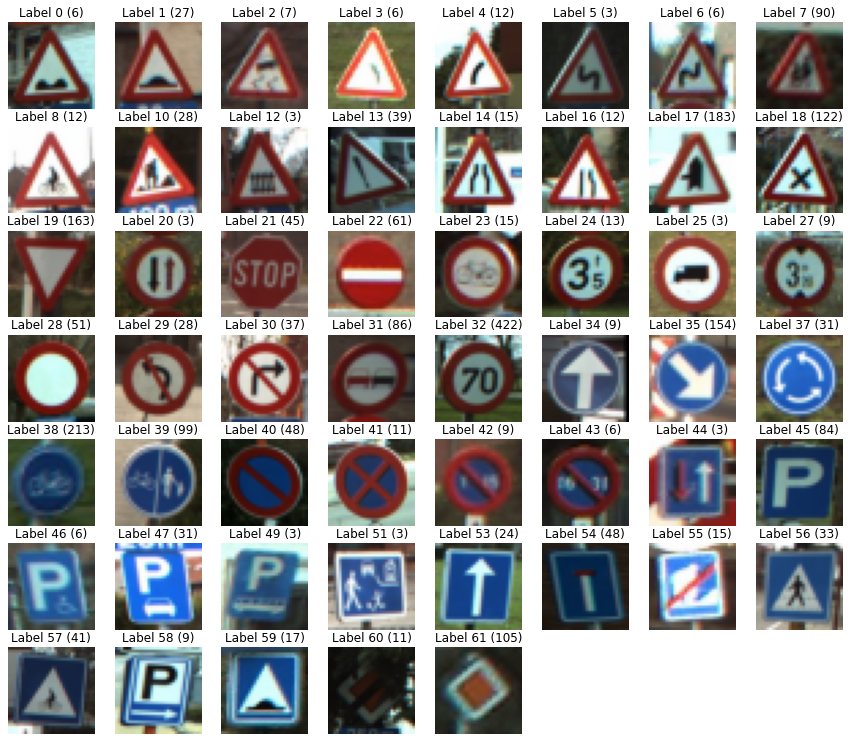

In [ ]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [ ]:
# Run predictions against the full test set.
predicted = np.argmax(model.predict(np.array(test_images32)), axis=1)
# Calculate how many matches we got.
accuracy = np.mean(predicted == test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.662
